### Race to the Bottom: A Comparison Between Gravity-Base Foundations and XXXL-Monopiles for U.S. Offshore Wind
This notebook processes WISDEM results for the IEA-15MW turbine using monopile and a gravity based foundation

In [1]:
import os

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import numpy as np

from helper_functions import init_fig_axis, fig_format, save


### Directory Set up and User Inputs

In [2]:
ROOT = os.getcwd()
FIGDIR = os.path.join(ROOT, "_figures")
if not FIGDIR:
    os.mkdir(FIGDIR)

# Which machine ratings should we run [in MW]
ratings = [15] # [15, 20, 22, 25]

# Which depths should we run [in m]
depths  = [20, 30, 40, 50, 60] # [20, 30, 40, 50, 60]

save_plots = False
case = "mono" # or grav
name = "newtest9" # suffix for plots

fout_name = 'equinor_turb_output.npz'

In [3]:
# Data containers to hold outputs from test matrix
m_tow = np.zeros((len(ratings), len(depths)))
c_tow = np.zeros(m_tow.shape)
m_mono = np.zeros(m_tow.shape)
c_mono = np.zeros(m_tow.shape)
l_mono = np.zeros(m_tow.shape)
m_trans = np.zeros(m_tow.shape)
c_trans = np.zeros(m_tow.shape)
m_struct = np.zeros(m_tow.shape)
rating_mat = np.zeros(m_tow.shape)
depth_mat = np.zeros(m_tow.shape)
m_nacelle = np.zeros(m_tow.shape)
c_turbine = np.zeros(m_tow.shape)

# When there is an array of data at every point, that could change size, use nested dictionaries instead of 3-D matrices
zpts = {}
diam = {}
thick = {}

# Loop over all ratings, and descend into folder
for ri, r in enumerate(ratings):
    os.chdir(f'{r}mw')

    # Initialize nested dictionaries
    zpts[r] = {}
    diam[r] = {}
    thick[r] = {}

    # Loop over all depths, and descend into folder
    for di, d in enumerate(depths):
        os.chdir(f'{d}m')

        # Store ratings and depths for easy plotting
        rating_mat[ri,di] = r
        depth_mat[ri,di] = d

        # Read archive of outputs from WISDEM run
        fout_path = os.path.join('outputs', fout_name)
        if not os.path.exists(fout_path): continue
        out_archive = np.load( fout_path )

        # Store outputs into matrices.  List of available outputs can be found in the WISDEM documentation or in the csv- or xlsx-files
        m_tow[ri,di] = out_archive['towerse.tower_mass_kg']
        c_tow[ri,di] = out_archive['towerse.tower_cost_USD']
        m_mono[ri,di] = out_archive['fixedse.monopile_mass_kg']
        c_mono[ri,di] = out_archive['fixedse.monopile_cost_USD']
        l_mono[ri,di] = out_archive['fixedse.monopile_height_m']
        m_struct[ri,di] = out_archive['fixedse.structural_mass_kg']
        m_nacelle[ri,di] = out_archive['orbit.nacelle_mass_t']
        c_turbine[ri,di] = out_archive['orbit.turbine_capex_USD/kW']

        # Store the arrays for diameter, thickness, and z-points in the nested dictionary
        zpts[r][d] = np.r_[out_archive['monopile.ref_axis_m'][:,2], out_archive['tower.ref_axis_m'][:,2]]
        diam[r][d] = np.r_[out_archive['monopile.diameter_m'], out_archive['tower.diameter_m']]
        thick[r][d] = np.r_[out_archive['monopile.layer_thickness_m'][0,:], out_archive['tower.layer_thickness_m'][0,:]]

        os.chdir('..')
    os.chdir('..')

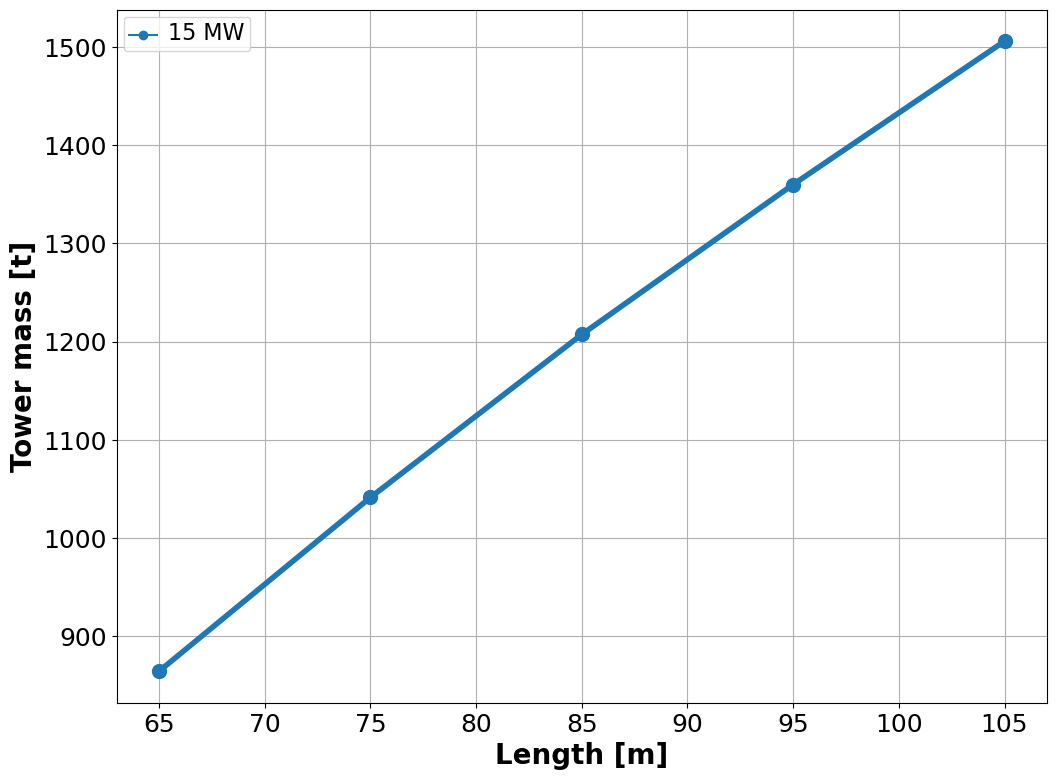

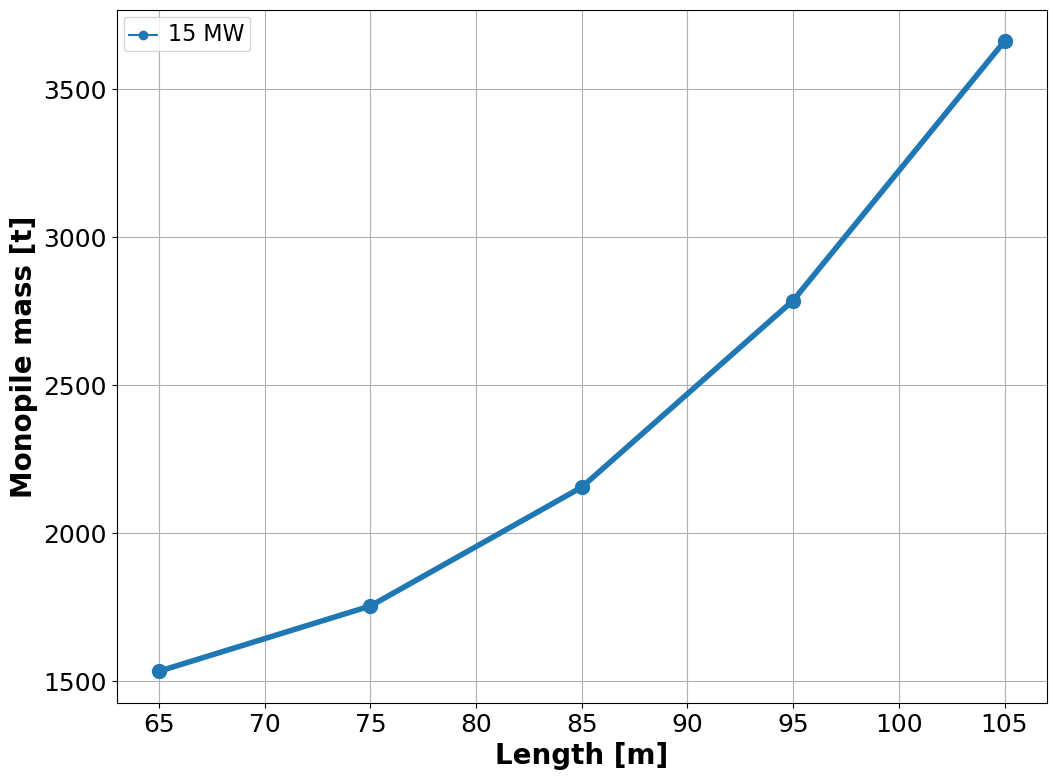

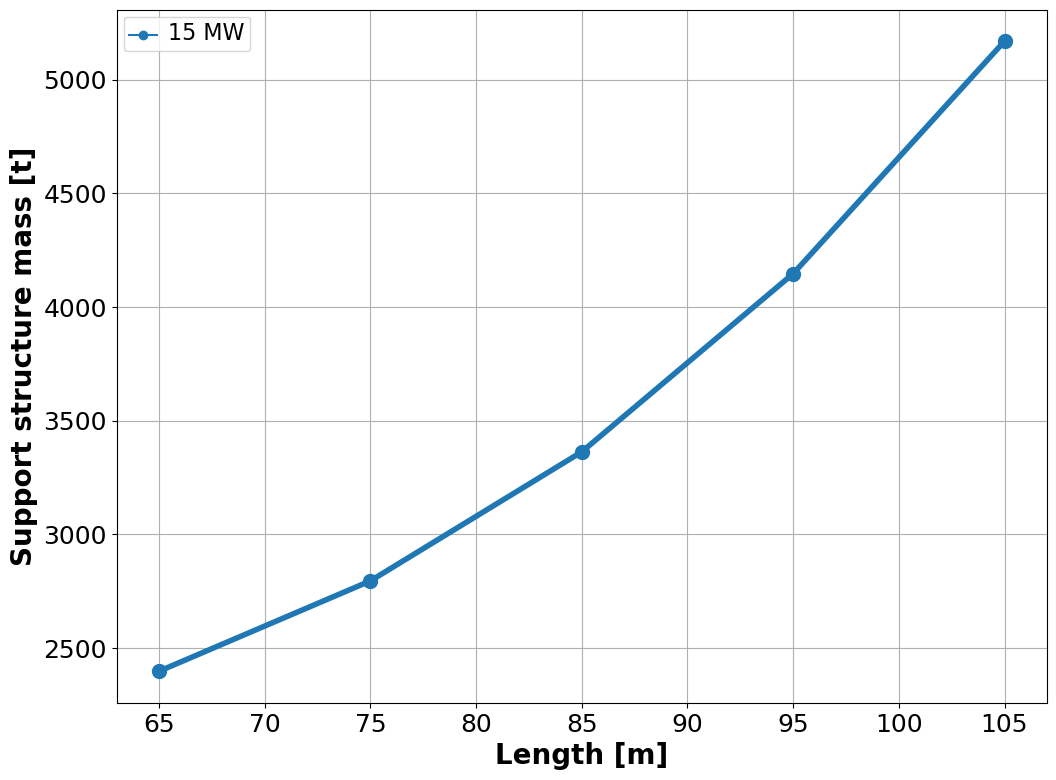

In [4]:
# Create figures of design point trends for tower mass, monopile mass, combined mass
xstr = 'Depth [m]'
legstr = [f"{r} MW" for r in ratings] # ['15 MW','20 MW','22 MW','25 MW']
fig, ax = init_fig_axis()
ax.plot(depths, 1e-3*m_tow.T,'-o')
ax.grid()
ax.set_xlabel(xstr)
ax.set_ylabel('Tower mass [t]')
ax.legend(legstr)
fig_format(ax)
if save_plots: save(fig,
                    os.path.join(FIGDIR, f"{case}_cases-tower_mass_{name}")
                    )

fig, ax = init_fig_axis()
ax.plot(depths, 1e-3*m_mono.T, '-o')
ax.grid()
ax.set_xlabel(xstr)
ax.set_ylabel('Monopile mass [t]')
ax.legend(legstr)
fig_format(ax)
if save_plots: save(fig,
                    os.path.join(FIGDIR, f"{case}_cases-monopile_mass_{name}")
                    )

fig, ax = init_fig_axis()
# l_mono.T
ax.plot(depths, 1e-3*m_struct.T, '-o')
ax.grid()
ax.set_xlabel(xstr)
ax.set_ylabel('Support structure mass [t]')
ax.legend(legstr)
fig_format(ax)
if save_plots: save(fig,
                    os.path.join(FIGDIR, f"{case}_cases-structural_mass_{name}")
                    )
plt.show()

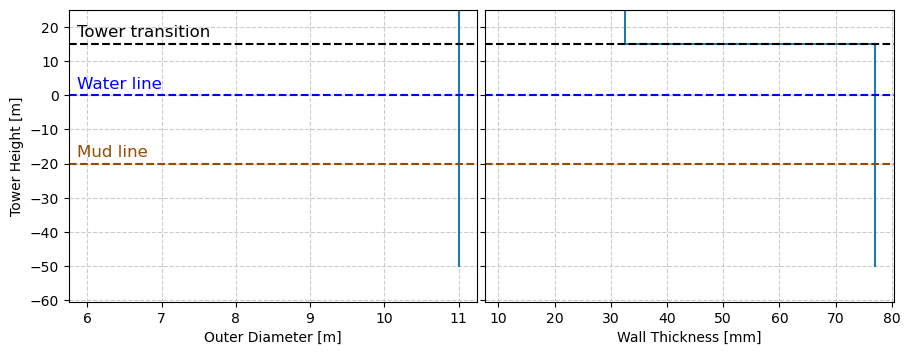

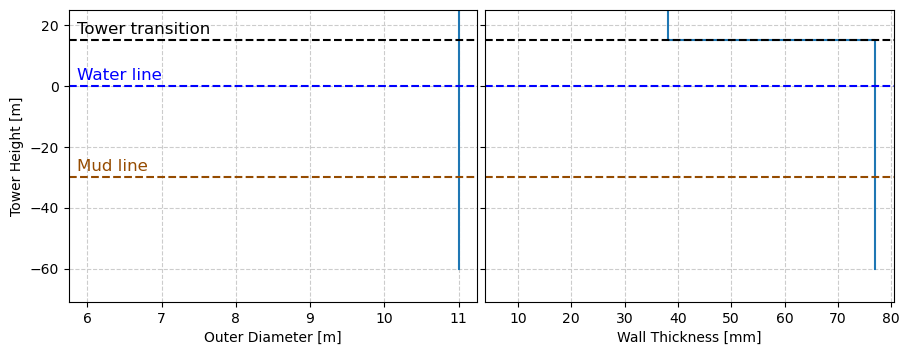

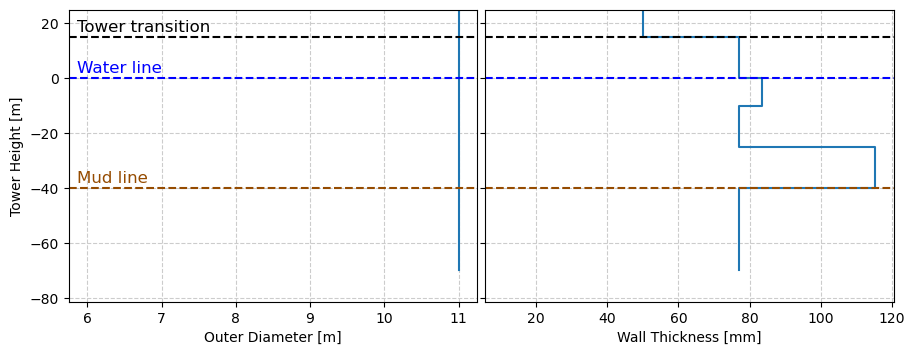

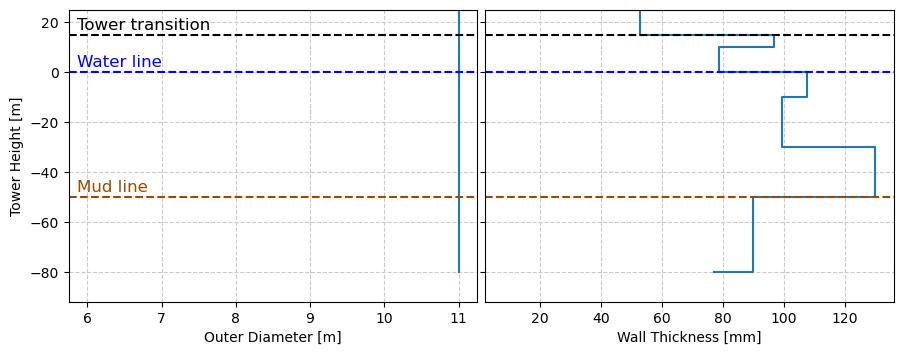

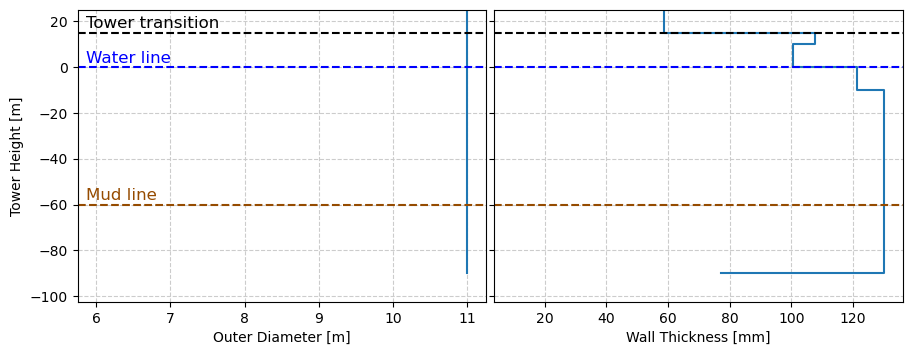

In [5]:
# Tower geometry profiles by depth
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
brown = np.array([150.0, 75.0, 0.0]) / 256.0
for di, d in enumerate(depths):
    ftow = plt.figure(figsize=(11, 4))
    ax1 = ftow.add_subplot(121)
    for ri, r in enumerate(ratings):
        ax1.plot(diam[r][d], zpts[r][d], '-', color=colors[ri], label=f'{r} MW')
    vx = ax1.get_xlim()
    vy = ax1.get_ylim()
    zs = zpts[r][d]
    if zs.min() < -5.0:
        h_trans = out_archive['monopile.ref_axis_m'][-1,2]
        ax1.plot(vx, np.zeros(2), color="b", linestyle="--")
        ax1.plot(vx, -d * np.ones(2), color=brown, linestyle="--")
        ax1.plot(vx, h_trans * np.ones(2), color="k", linestyle="--")
        ax1.text(vx[0] + 0.02 * np.diff(vx), 2, "Water line", color="b", fontsize=12)
        ax1.text(vx[0] + 0.02 * np.diff(vx), -d + 2, "Mud line", color=brown, fontsize=12)
        ax1.text(vx[0] + 0.02 * np.diff(vx), h_trans + 2, "Tower transition", color="k", fontsize=12)
    ax1.set_xlim(vx)
    ax1.set_ylim([vy[0], 25])
    plt.xlabel("Outer Diameter [m]")
    plt.ylabel("Tower Height [m]")
    plt.grid(color=[0.8, 0.8, 0.8], linestyle="--")

    ax2 = ftow.add_subplot(122)
    for ri, r in enumerate(ratings):
        ax2.step(1e3 * thick[r][d], zpts[r][d], '-', color=colors[ri], label=f'{r} MW', where="post")
    vx = ax2.get_xlim()
    vy = ax2.get_ylim()
    if zs.min() < -5.0:
        ax2.plot(vx, np.zeros(2), color="b", linestyle="--")
        ax2.plot(vx, -d * np.ones(2), color=brown, linestyle="--")
        ax2.plot(vx, h_trans * np.ones(2), color="k", linestyle="--")
    ax2.set_xlim(vx)
    ax2.set_ylim([vy[0], 25])
    plt.xlabel("Wall Thickness [mm]")
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.grid(color=[0.8, 0.8, 0.8], linestyle="--")
    plt.subplots_adjust(bottom=0.15, left=0.15)
    ftow.subplots_adjust(hspace=0.02, wspace=0.02, bottom=0.15, left=0.15)
    if save_plots: save(ftow,
                        os.path.join(FIGDIR, f'tower-{case}_depth{d}_{name}')) #, pad_inches=0.1, bbox_inches="tight")
plt.show()